# Project Idea 1: 

- Make a simplifying assumption between the **loan issuance date** and application dates,
convert the approved loans into the formats of rejected loan applications.
- Use supervised technique and clustering, describe (reverse engineering) 
the loan approval criterion of **Lending Club**.

    - Challenges: The aggregated data has more than $20M$ samples. This is
        beyond the coverage of many ML algorithms. How do you design an apporach 
        which allows you to train on such a large size data? The problem is
        particularly serious for training **pooled** models.
    - When you apply supervised technique, it might involve imbalanced classification.
    How would you handle 'im-balanced dataset' like this?
    
- Are there poor performing approved loans which should be rejected?
- What is the business impact (pros and cons) of rejecting such non-performing loans?
</a><br>
# Structure: 
- <a href="#preprocessing">Preprocessing</a><br>
- <a href="#function">Function</a><br>
- <a href="#ml">Machine Learning</a><br>
    - Unsupervised Machine Learning  
        - <a href="#kmeans">K Means</a><br> 

    - Supervised Machine Learning      
        - <a href="#decision">Decision Tree</a><br>
        - <a href="#rf">Random Forest</a><br>
        - <a href="#svm">SVM</a><br>
        - <a href="#xgboost">XGBoost</a><br>
        - <a href="#logistic">Logistic Regression</a><br>
        - <a href="#naive">Naive Bayes Classifier</a><br>
        - <a href="#neighbor">Nearest Neighbor</a><br>
- <a href="#imbalance">Handling Imbalanced Data</a><br>
    - <a href="#smote">SMOTE</a><br>

In [2]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression 
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 


In [ ]:
df_raw_accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')
df_raw_rejected = pd.read_csv('rejected_2007_to_2018Q4.csv')

In [ ]:
df_raw_accepted.sample(frac=0.001).to_csv('sample_accepted.csv')
df_raw_rejected.sample(frac=0.001).to_csv('sample_rejected.csv')

In [131]:
sample_accepted = pd.read_csv('sample_accepted.csv')
sample_rejected = pd.read_csv('sample_rejected.csv')

In [211]:
sample_accepted.shape

(2261, 152)

In [212]:
sample_rejected.shape

(27649, 10)

In [85]:
sample_accepted = sample_accepted.sample(2000)
sample_rejected = sample_rejected.sample(2000)

 <p><a name="preprocessing"></a></p>
 
 ## Preprocessing Test

In [ ]:
accepted = sample_accepted.copy()
rejected = sample_rejected.copy()

In [ ]:
rejected = rejected.iloc[:,1:9]
rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                         "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                         "State": "addr_state", "Employment Length": "emp_length"})
rejected['loan_status'] = 0

rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*consolidation.*$)', 'debt_consolidation')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*loan.*$)', 'debt_consolidation')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*debt.*$)', 'debt_consolidation')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*card.*$)', 'credit_card')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*credit.*$)', 'credit_card')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*house.*$)', 'house')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*business.*$)', 'small_business')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*car.*$)', 'car')
rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*education.*$)', 'education')


rejected['purpose'] = np.where(rejected['purpose'].isin(['house', 'credit_card', 'major_purchase', 'debt_consolidation',
   'other', 'moving', 'small_business', 'home_improvement',
   'vacation', 'medical', 'renewable_energy', 'car', 'wedding']), rejected['purpose'], 'other')

rejected['app_date'] = pd.to_datetime(rejected['app_date'])
rejected['app_year'] = rejected['app_date'].dt.year
rejected['app_month'] = rejected['app_date'].dt.month

rejected = rejected.drop(columns = 'app_date')

rejected['dti'] = rejected['dti'].str.replace('%','')

In [ ]:
accepted = sample_accepted[['loan_amnt', 'purpose', 'dti',
       'zip_code', 'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]

In [ ]:
accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
accepted['app_year'] = accepted['issue_d'].dt.year
accepted['app_month'] = accepted['issue_d'].dt.month

accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])

accepted = accepted.replace({'loan_status' : { 'Charged Off' : 'rejected', 'Late (16-30 days)' : 'rejected', 
                                   'Late (31-120 days)' : 'rejected',
                                   'Does not meet the credit policy. Status:Charged Off' : 'rejected',
                                   'Fully Paid' : 'accepted', 'Current' : 'accepted',
                                   'In Grace Period' : 'accepted',
                                   'Does not meet the credit policy. Status:Fully Paid' : 'accepted'}})

In [ ]:
df_processed = pd.concat([accepted, rejected], sort=True)

In [ ]:
total = df_processed.isnull().sum().sort_values(ascending=False)
percent = (df_processed.isnull().sum()/df_processed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

 <p><a name="function"></a></p>
 
 ## Processing Function 

In [235]:
'''
For applications prior to November 5, 2013 the risk score is the borrower's FICO score. 
For applications after November 5, 2013 the risk score is the borrower's Vantage score.
'''

def data_process(df_accepted,df_rejected):
    
    accepted = df_accepted.copy()
    rejected = df_rejected.copy()
    
    # Processing accepted data 
    accepted = accepted[['loan_amnt', 'purpose', 'dti',
       'zip_code', 'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]
    
    accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
    accepted['app_year'] = accepted['issue_d'].dt.year
    accepted['app_month'] = accepted['issue_d'].dt.month

    accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
    accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])

#     if reverse = False:
#         accepted = accepted.replace({'loan_status' : { 'Charged Off' : 'rejected', 'Late (16-30 days)' : 'rejected', 
#                                        'Late (31-120 days)' : 'rejected',
#                                        'Does not meet the credit policy. Status:Charged Off' : 'rejected',
#                                        'Fully Paid' : 'accepted', 'Current' : 'accepted',
#                                        'In Grace Period' : 'accepted',
#                                        'Does not meet the credit policy. Status:Fully Paid' : 'accepted'}})

    accepted['loan_status'] =1
            
    
    # Processing rejected data 
    rejected = rejected.iloc[:,1:9]
    rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                             "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                             "State": "addr_state", "Employment Length": "emp_length"})
    rejected['loan_status'] = 0
    
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*consolidation.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*loan.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*debt.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*card.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*credit.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*house.*$)', 'house')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*business.*$)', 'small_business')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*car.*$)', 'car')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*education.*$)', 'education')
    
    
    rejected['purpose'] = np.where(rejected['purpose'].isin(['house', 'credit_card', 'major_purchase', 'debt_consolidation',
       'other', 'moving', 'small_business', 'home_improvement',
       'vacation', 'medical', 'renewable_energy', 'car', 'wedding']), rejected['purpose'], 'other')

    rejected['app_date'] = pd.to_datetime(rejected['app_date'])
    rejected['app_year'] = rejected['app_date'].dt.year
    rejected['app_month'] = rejected['app_date'].dt.month

    rejected = rejected.drop(columns = 'app_date')
    
    rejected['dti'] = rejected['dti'].str.replace('%','')
    
    # Merge accepted and rejected data for later process
    df_processed = pd.concat([accepted, rejected], sort=True)
    

    # Convert categorical to numerical-- 10 means more than 10 years 
    df_processed['emp_length'] = df_processed['emp_length'].str.extract('(\d+)')


    # Missing Values: risk_score, emp_length, dti
    df_processed['emp_length'] = df_processed['emp_length'].fillna(0)
    df_processed['emp_length'] = df_processed['emp_length'].astype(int)
    df_processed['risk_score'] = df_processed['risk_score'].fillna(0)
    df_processed['dti'] = df_processed['dti'].fillna(0)
    df_processed['dti'] = df_processed['dti'].astype(float)
    
    df_processed = df_processed.drop(['purpose'], axis = 1)
    df_processed = pd.get_dummies(df_processed)
    
    
    return df_processed

df_processed = data_process(sample_accepted,sample_rejected)
# df_undummpy = df_processed.copy()

In [ ]:
df_processed = data_process(sample_accepted,sample_rejected)

In [88]:
df_processed.shape

(4000, 10)

 <p><a name="ml"></a></p>
 
 # Machine Learning
 
- Unsupervised Machine Learning  
    - <a href="#kmeans">K Means</a><br> 
    
- Supervised Machine Learning      
    - <a href="#decision">Decision Tree</a><br>
    - <a href="#rf">Random Forest</a><br>
    - <a href="#svm">SVM</a><br>
    - <a href="#xgboost">XGBoost</a><br>
    - <a href="#logistic">Logistic Regression</a><br>
    - <a href="#naive">Naive Bayes Classifier</a><br>
    - <a href="#neighbor">Nearest Neighbor</a><br>
</a><br>
- Working on
    Neural Networks
</a><br>
- Links: 
    - https://github.com/perryrjohnson/Walk-Score/blob/master/feature%20engineering.ipynb
    - https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score


from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# The predicted column is "loan_status" , split the data into training and test sets.
x_m = df_processed.drop(['loan_status'], axis=1)
y_m = df_processed.loc[:,'loan_status']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

 <p><a name="kmeans"></a></p>
 
 ### K Means
 
 Link: https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
</a></p> http://benalexkeen.com/k-means-clustering-in-python/
 
 k-means clustering is very sensitive to scale due to its reliance on Euclidean distance so be sure to normalize data if there are likely to be scaling problems.
If there are some symmetries in your data, some of the labels may be mis-labelled
It is recommended to do the same k-means with different initial centroids and take the most common label.

In [93]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [223]:
df_processed.head()

,app_month,app_year,dti,emp_length,loan_amnt,risk_score,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_000xx,zip_code_002xx,zip_code_008xx,zip_code_010xx,zip_code_011xx,zip_code_012xx,zip_code_013xx,zip_code_014xx,zip_code_015xx,zip_code_016xx,zip_code_017xx,zip_code_018xx,zip_code_019xx,zip_code_020xx,zip_code_021xx,zip_code_022xx,zip_code_023xx,zip_code_024xx,zip_code_025xx,zip_code_026xx,zip_code_027xx,zip_code_028xx,zip_code_029xx,zip_code_030xx,zip_code_031xx,zip_code_032xx,zip_code_033xx,zip_code_034xx,zip_code_035xx,zip_code_036xx,zip_code_037xx,zip_code_038xx,zip_code_040xx,zip_code_041xx,zip_code_042xx,zip_code_043xx,zip_code_044xx,zip_code_045xx,zip_code_046xx,zip_code_047xx,zip_code_048xx,zip_code_049xx,zip_code_050xx,zip_code_051xx,zip_code_052xx,zip_code_053xx,zip_code_054xx,zip_code_056xx,zip_code_057xx,zip_code_058xx,zip_code_059xx,zip_code_060xx,zip_code_061xx,zip_code_062xx,zip_code_063xx,zip_code_064xx,zip_code_065xx,zip_code_066xx,zip_code_067xx,zip_code_068xx,zip_code_069xx,zip_code_070xx,zip_code_071xx,zip_code_072xx,zip_code_073xx,zip_code_074xx,zip_code_075xx,zip_code_076xx,zip_code_077xx,zip_code_078xx,zip_code_079xx,zip_code_080xx,zip_code_081xx,zip_code_082xx,zip_code_083xx,zip_code_084xx,zip_code_085xx,zip_code_086xx,zip_code_087xx,zip_code_088xx,zip_code_089xx,zip_code_096xx,zip_code_098xx,zip_code_100xx,zip_code_101xx,zip_code_102xx,zip_code_103xx,zip_code_104xx,zip_code_105xx,zip_code_106xx,zip_code_107xx,zip_code_108xx,zip_code_109xx,zip_code_110xx,zip_code_111xx,zip_code_112xx,zip_code_113xx,zip_code_114xx,zip_code_115xx,zip_code_116xx,zip_code_117xx,zip_code_118xx,zip_code_119xx,zip_code_120xx,zip_code_121xx,zip_code_122xx,zip_code_123xx,zip_code_124xx,zip_code_125xx,zip_code_126xx,zip_code_127xx,zip_code_128xx,zip_code_129xx,zip_code_130xx,zip_code_131xx,zip_code_132xx,zip_code_133xx,zip_code_134xx,zip_code_135xx,zip_code_136xx,zip_code_137xx,zip_code_138xx,zip_code_139xx,zip_code_140xx,zip_code_141xx,zip_code_142xx,zip_code_143xx,zip_code_144xx,zip_code_145xx,zip_code_146xx,zip_code_147xx,zip_code_148xx,zip_code_149xx,zip_code_150xx,zip_code_151xx,zip_code_152xx,zip_code_153xx,zip_code_154xx,zip_code_155xx,zip_code_156xx,zip_code_157xx,zip_code_158xx,zip_code_159xx,zip_code_160xx,zip_code_161xx,zip_code_162xx,zip_code_163xx,zip_code_164xx,zip_code_165xx,zip_code_166xx,zip_code_167xx,zip_code_168xx,zip_code_169xx,zip_code_170xx,zip_code_171xx,zip_code_172xx,zip_code_173xx,zip_code_174xx,zip_code_175xx,zip_code_176xx,zip_code_177xx,zip_code_178xx,zip_code_179xx,zip_code_180xx,zip_code_181xx,zip_code_182xx,zip_code_183xx,zip_code_184xx,zip_code_185xx,zip_code_186xx,zip_code_187xx,zip_code_188xx,zip_code_189xx,zip_code_190xx,zip_code_191xx,zip_code_193xx,zip_code_194xx,zip_code_195xx,zip_code_196xx,zip_code_197xx,zip_code_198xx,zip_code_199xx,zip_code_200xx,zip_code_201xx,zip_code_205xx,zip_code_206xx,zip_code_207xx,zip_code_208xx,zip_code_209xx,zip_code_210xx,zip_code_211xx,zip_code_212xx,zip_code_214xx,zip_code_215xx,zip_code_216xx,zip_code_217xx,zip_code_218xx,zip_code_219xx,zip_code_220xx,zip_code_221

In [236]:
# Drop the sales price column to only keep the features
df_processed = df_processed.drop(['loan_status'], axis = 1)

In [237]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_processed)
df_processed = pd.DataFrame(scaled_df, columns=df_processed.columns)

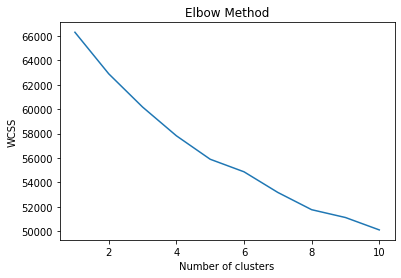

In [241]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_processed)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [238]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans = kmeans.fit(df_processed)
labels = kmeans.predict(df_processed)
C = kmeans.cluster_centers_

In [239]:
df_undummpy ['label'] = labels.tolist()
df_undummpy.groupby(['label','loan_status']).size()

label  loan_status
0      0              14744
       1                 27
1      0               7149
       1               1702
2      0               3268
       1                325
3      0               2488
       1                207
dtype: int64

In [240]:
df_undummpy[df_undummpy['label']==0].sample(10)

,addr_state,app_month,app_year,dti,emp_length,loan_amnt,loan_status,risk_score,zip_code,label
25184,NY,2,2017,11.49,5,1500.0,0,0.0,104xx,0
17246,NY,6,2018,100.00,1,10000.0,0,0.0,104xx,0
23613,FL,6,2017,9999.00,1,5000.0,0,0.0,322xx,0
26649,FL,1,2017,2.36,5,1000.0,0,0.0,346xx,0
16012,MT,11,2015,4.75,1,1500.0,0,0.0,599xx,0
4543,KS,8,2016,26.76,1,2000.0,0,0.0,660xx,0
23355,NH,12,2016,-1.00,5,10000.0,0,0.0,031xx,0
10132,MD,6,2017,28.23,1,10000.0,0,0.0,207xx,0
11707,FL,6,2018,32.27,1,1500.0,0,0.0,331xx,0
11670,NY,3,2018,25.50,1,30000.0,0,0.0,103xx,0


 <p><a name="decision"></a></p>
 
 ### Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')

y_pred = tree.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = tree.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features = X_train.columns
importance = tree.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

 <p><a name="rf"></a></p>
 
 ### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

# Fit on training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Model Accuracy: {model.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [ ]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

In [ ]:
features = X_train.columns
importance = model.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);


# feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# feature_imp.head(15).plot.barh()

In [ ]:
forest = RandomForestRegressor(n_jobs=2)

# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700, 800]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [20, 22, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

forest_grid = RandomizedSearchCV(forest, param_distributions= random_grid, 
                                 cv = 5, scoring= 'neg_mean_squared_error')

forest_grid.fit(X_train, y_train)

In [ ]:
forest_grid_predictions =forest_grid.best_estimator_.predict(X_test)

In [ ]:
confusion_matrix(y_test, forest_grid_predictions)

In [ ]:
features = X_train.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14)

 <p><a name="svm"></a></p>
 
 ### SVM

In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = svc.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_svc)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix)
print(classification_report(y_test, y_pred_svc))
# logit_roc_auc = roc_auc_score(y_pred_svc, logreg.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_pred_svc, logreg.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [ ]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

In [ ]:
grid = GridSearchCV(LinearSVC(),param_grid,refit = True, verbose=2)

In [ ]:
grid.fit(X_train,y_train)

 <p><a name="xgboost"></a></p>
 
 ### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

In [ ]:
preds = grid.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

 <p><a name="logistic"></a></p>
 
 ### Logistic Regression
 
- Links: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [11]:
from sklearn.linear_model import LogisticRegression

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\miazh_000\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

print(confusion_matrix)

[[4947  624]
 [  48  363]]


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      5571
           1       0.37      0.88      0.52       411

    accuracy                           0.89      5982
   macro avg       0.68      0.89      0.73      5982
weighted avg       0.95      0.89      0.91      5982



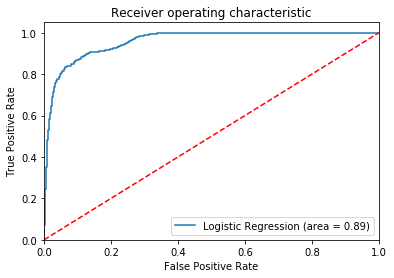

In [21]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

 <p><a name="naive"></a></p>
 
 ### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test) 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

 <p><a name="neighbor"></a></p>
 
 ### Nearest Neighbor

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_scaler  = scaler.fit_transform(X_train)
X_test_scaler  = scaler.fit_transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
pca_model.fit(X_train_scaler)
X_train = pca_model.transform(X_train_scaler)
X_test = pca_model.transform(X_test_scaler)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 2

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaler, y_train) 

In [ ]:
y_pred = knn_model.predict(X_test_scaler)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = knn_model.predict_proba(X_test_scaler)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

 <p><a name="imbalance"></a></p>
 
 ## Handling Imbalanced Data
 
 - links: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

 <p><a name="smote"></a></p>
 
 ### SMOTE

In [1]:
# from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [8]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [13]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)


0.9428284854563691

In [14]:
# f1 score
f1_score(y_test, smote_pred)

0.655241935483871

In [15]:
recall_score(y_test, smote_pred)

0.7907542579075426

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, smote_pred)
print(confusion_matrix)
print(classification_report(y_test, smote_pred))

logit_roc_auc = roc_auc_score(y_test, smote_pred)
fpr, tpr, thresholds = roc_curve(y_test, smote_pred[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

[[5315  256]
 [  86  325]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5571
           1       0.56      0.79      0.66       411

    accuracy                           0.94      5982
   macro avg       0.77      0.87      0.81      5982
weighted avg       0.95      0.94      0.95      5982



IndexError: too many indices for array